In [107]:
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load data

Loading the data as a regular `pandas.DataFrame`. Then we proceed by converting the `time` feature to `pandas.DateTime`, before making it the index of the dataframe. 

In [108]:
# Load data
data = pd.read_csv('weather_bcn.csv')

# Extract only pres and time columns
data = pd.DataFrame(data[['pres', 'time']], index=data.index, columns=['pres', 'time'])

# Convert time column
data['time'] = pd.to_datetime(data['time'])

# Make time the index
data.set_index('time', inplace=True)
assert type(data.index) == pd.core.indexes.datetimes.DatetimeIndex

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1990-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pres    373 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are three null values out of 396 in the data set. We therefore use the Spline interpolation technique from sklearn

In [109]:
data['pres']= data['pres'].interpolate(option='spline')

data.head()

,pres
time,
1990-01-01,1023.80
1990-02-01,1024.65
1990-03-01,1025.50
1990-04-01,1013.10
1990-05-01,1013.50


### Split into train and test

Help method for splitting the data set into train and test set, s.t. test contains data for the year 2022.

In [110]:
def train_test_split(df):
    assert type(df.index) == pd.core.indexes.datetimes.DatetimeIndex
    
    # Extract data for 2022
    test = df[(df.index.year == 2022)]
    train = df.drop(test.index)

    return train, test

### Extract `pres`

Making two dataframes (train and test) containing only the index and the `pres` feature.

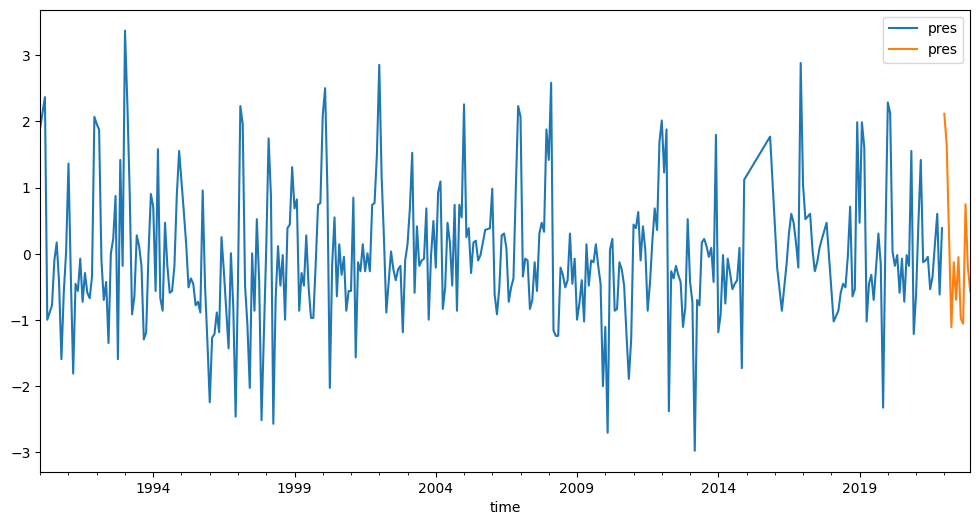

In [111]:
from sklearn.preprocessing import StandardScaler
train, test = train_test_split(data)

scaler = StandardScaler()

train = pd.DataFrame(data=scaler.fit_transform(train), index=train.index, columns=train.columns)
test = pd.DataFrame(data=scaler.fit_transform(test), index=test.index, columns=test.columns)


plt.rcParams['figure.figsize'] = 12,6
ax = train.plot();
test.plot(ax=ax);

### Stationarity in the data

#### Seasonal decomposition
To get an initial idea of the stationarity of the data, we use `seasonal_decompose` from statsmodels to plot trend, seasonality and residuals :
- **Trend:** the trend plot shows that the average temperature increases over time, thus indicating non-stationarity.
- **Seasonality:** the data is clearly seasonal. This was to be expected, as the average atmosphric pressure (pres) is seasonal throughout the year.
- **Residuals:** there appears to be no strong pattern in the residuals. 

Due to displayed trend and seasonality, the seasonal decomposition suggests that the data is non-stationary. 

#### ADF test
We also did an Augmented Dickey-Fuller test on the data. Both of the observations below suggests stationarity in the data:
- **ADF Test Statistc:** the test statistic is far more negative than the critical values at 1%, 5% and 10%. 
- **ADF p-value:** the p-value is very low.

The results from the ADF test and the observations from the decomposition suggests that the data is stationary after accounting for trend and seasonality.

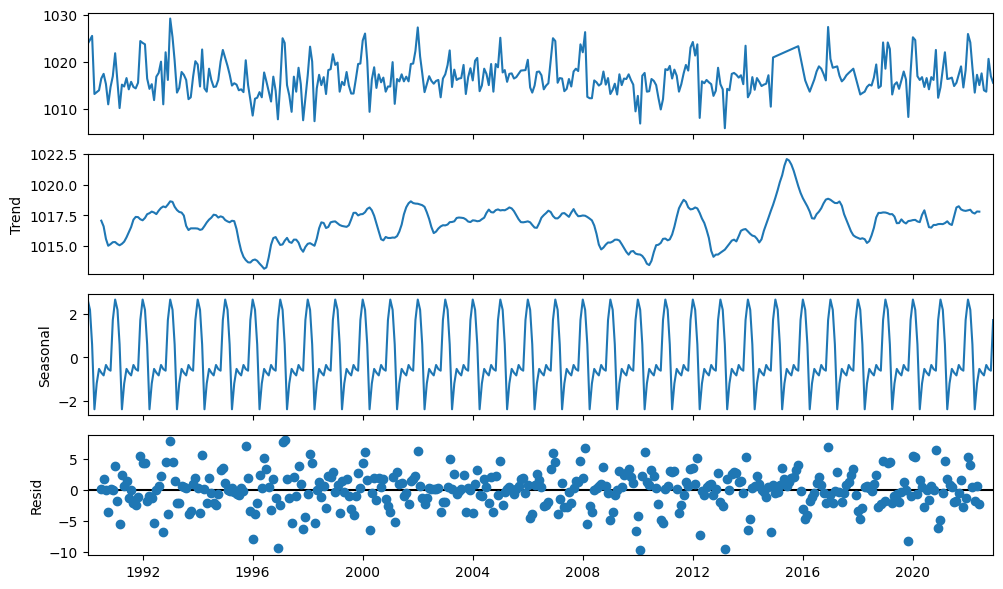

In [112]:
rcParams['figure.figsize'] = 10,6
result = seasonal_decompose(data)
result.plot();

In [113]:
adf = adfuller(train)
print('ADF test statistic:', adf[0])
print('ADF p-values:', adf[1])
print('ADF number of lags used:', adf[2])
print('ADF number of observations:', adf[3])
print('ADF critical values:', adf[4])

ADF test statistic: -8.530672446448591
ADF p-values: 1.0397811427848158e-13
ADF number of lags used: 3
ADF number of observations: 380
ADF critical values: {'1%': -3.4476763783532585, '5%': -2.869176103659426, '10%': -2.570837873961219}


## ARIMA

### ARIMA Without Seasonality

We start by applying `auto_arima` without seasonality (using default parameters).

In [114]:
arima_unseasonal = auto_arima(train)
arima_unseasonal.fit(train)

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

The optimal parameters found by `auto_arima` has `d=0`, supporting our observation on stationarity.

In [115]:
forecast_unseasonal = arima_unseasonal.predict(n_periods= len(test))
forecast_unseasonal = pd.DataFrame(forecast_unseasonal,index = test.index,columns=['ARIMA forecast'])

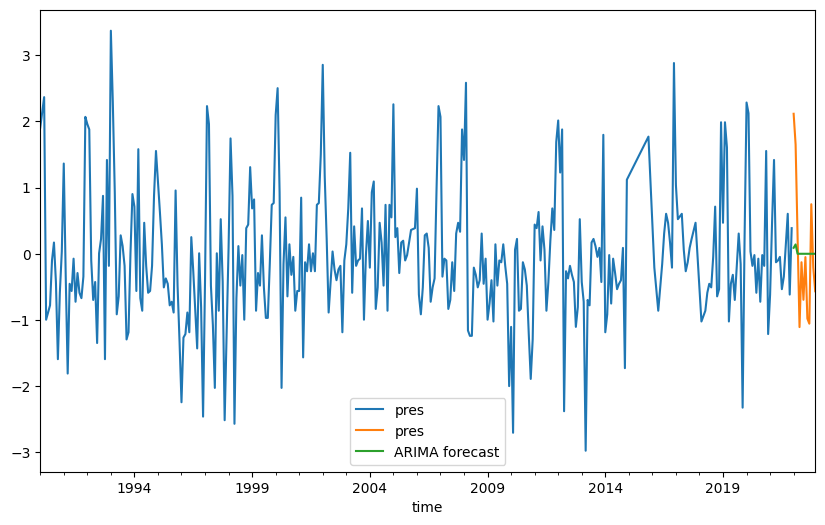

In [116]:
ax1 = train.plot()
test.plot(ax=ax1)
forecast_unseasonal.plot(ax=ax1);

In [117]:
print('ARIMA auto MSE:', round(mean_squared_error(test, forecast_unseasonal),2))
print('ARIMA auto MAE:', round(mean_absolute_error(test, forecast_unseasonal),3))

ARIMA auto MSE: 0.93
ARIMA auto MAE: 0.779


### ARIMA With Seasonality

We proceed by training a new ARIMA model, this time with the annual seasonality shown by the decomposition (`m=12`).

In [118]:
arima_seasonal = auto_arima(train, error_action='ignore', seasonal=True, m=12)
arima_seasonal.fit(train)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [119]:
forecast_seasonal = arima_seasonal.predict(n_periods=len(test))
forecast_seasonal = pd.DataFrame(forecast_seasonal,index = test.index,columns=['ARIMA forecast (seasonal)'])

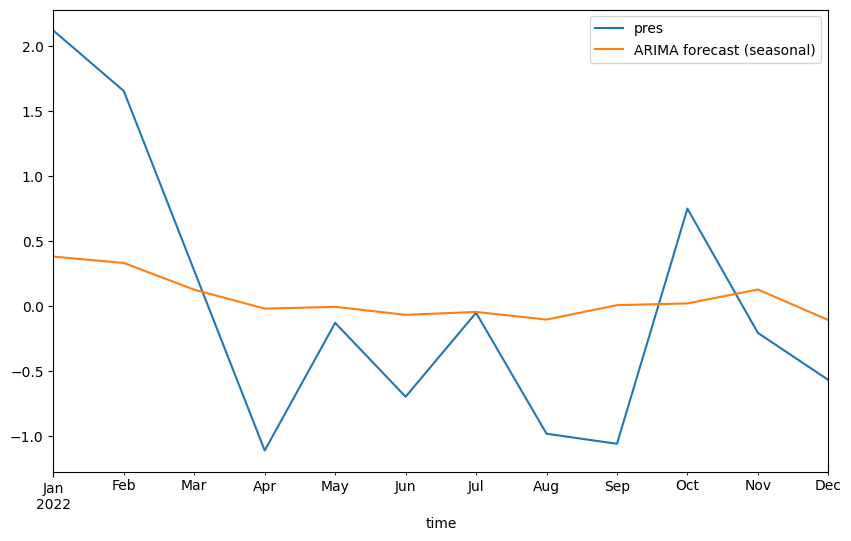

In [136]:
ax1 = test.plot()
forecast_seasonal.plot(ax=ax1);

In [121]:
print('ARIMA seasonal MSE:', round(mean_squared_error(test, forecast_seasonal),2))
print('ARIMA seasonal MAE:', round(mean_absolute_error(test, forecast_seasonal),3))

ARIMA seasonal MSE: 0.76
ARIMA seasonal MAE: 0.709


## Exponential Smoothing

In [122]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


ES_forecaster = ExponentialSmoothing(
    endog=train['pres'],
    seasonal='add',
    seasonal_periods=12,
    trend='add'
).fit()


# Forecast future values
ES_forecast = ES_forecaster.forecast(12) 

ES_forecast = pd.DataFrame(ES_forecast, index = test.index,columns=['Exponential smoothing'])

/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


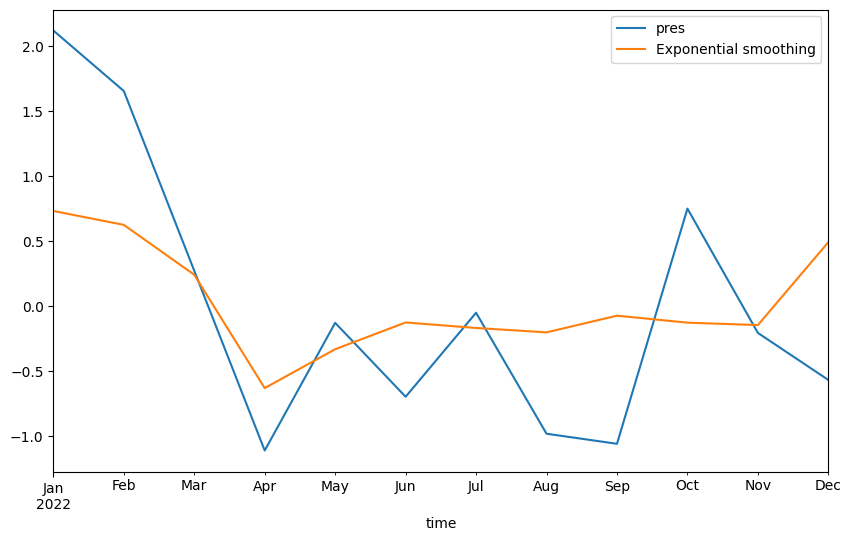

In [134]:

# ax1 = train.plot()
ax1 = test.plot()
ES_forecast.plot(ax=ax1);

In [135]:
print('Exponential Smoothing MSE:', round(mean_squared_error(test, ES_forecast),2))
print('Exponential Smoothing MAE:', round(mean_absolute_error(test, ES_forecast),3))

Exponential Smoothing MSE: 0.59
Exponential Smoothing MAE: 0.63


## Lag features

To enable the use of a regression model, we extract some features from the `pres` column:
- **Quarter** - the quarter of the year.
- **Month** - the month of the year.
- **Last month** - the `pres` value of last month. Lag feature.
- **Last year** - the `pres` value of last year. Lag feature.

In [125]:
lag_df = pd.DataFrame(data=train)

def extract_quarter(month):
    if month <= 3:
        return 1
    elif month <= 6:
        return 2
    elif month <= 9:
        return 3
    else:
        return 4
    
# Add month feature
lag_df['month'] = lag_df.index.month

# Add quarterly feature
lag_df['quarter'] = lag_df['month'].apply(extract_quarter)

In [126]:
# To lag last year's value, we need to see if the index is continuous
continuous_range = pd.date_range(start=lag_df.index.min(), end=lag_df.index.max(), freq='MS')
assert (len(continuous_range) == len(lag_df.index) and all(continuous_range == lag_df.index))

# Lag values
lag_df['last_month'] = lag_df['pres'].shift(1)
lag_df['last_2_month'] = lag_df['pres'].shift(2)
lag_df['last_3_month'] = lag_df['pres'].shift(3)
lag_df['last_year'] = lag_df['pres'].shift(12)

# Because of the lag from the previous year, we need to drop the first 12 entries
lag_df = lag_df.iloc[12:]

### Train model

We opt for the `HistGradientBoostRegressor` from scikit-learn. 

In [127]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Split data into X and y
y_train = lag_df['pres']
X_train = lag_df.drop('pres', axis=1, inplace=False)

# Train the model
HGBR_model = HistGradientBoostingRegressor(random_state=42)
HGBR_model.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

Next we need to prepare the forecasting data. As the next feature is dependent on the previous feature, and we will predict for the coming 12 months, we apply *recursive forecasting*.

In [128]:
# Make DataFrame for the data to predict and for the predictions
forecast_df = pd.DataFrame(index=[test.index[0]])
predictions_df = pd.DataFrame(index=test.index)

# Features in the prepared data
features = X_train.columns.tolist()

# Add month and quarter features
forecast_df['month'] = forecast_df.index.month
forecast_df['quarter'] = forecast_df['month'].apply(extract_quarter)

# Add the last known data to the forecast_df 
forecast_df = forecast_df.assign(
    last_month=lag_df.iloc[-1]['pres'],
    last_2_month=lag_df.iloc[-2]['pres'],
    last_3_month=lag_df.iloc[-3]['pres'],
    last_year=lag_df.iloc[-13]['pres'],
)

# Apply the recursive forecasting
for i in range(12):
    # Current index
    current_index = forecast_df.index[i]

    # Predict next months pres
    input_data = forecast_df.loc[[current_index], features]

    # input_data = pd.DataFrame(index=[current_index], data=forecast_df.iloc[i], columns=features)
    prediction = HGBR_model.predict(input_data)[0]

    # Add the prediction
    predictions_df.loc[predictions_df.index[i], 'pres'] = prediction

    # Update the input features for the next forecast
    if (i < 11): # Don't perform this step for the last month
        
        current_index = forecast_df.index[i]
        next_index = predictions_df.index[i+1]

        new_row = {
            'month': next_index.month, 
            'quarter': extract_quarter(next_index.month),
            'last_month': prediction,
            'last_2_month': forecast_df.loc[current_index, 'last_month'],
            'last_3_month': forecast_df.loc[current_index, 'last_2_month'],
            'last_year': lag_df['pres'].iloc[-12 + (next_index.month - 1)]
        }

        forecast_df = pd.concat([forecast_df, pd.DataFrame(new_row, index=[next_index])], ignore_index=False)

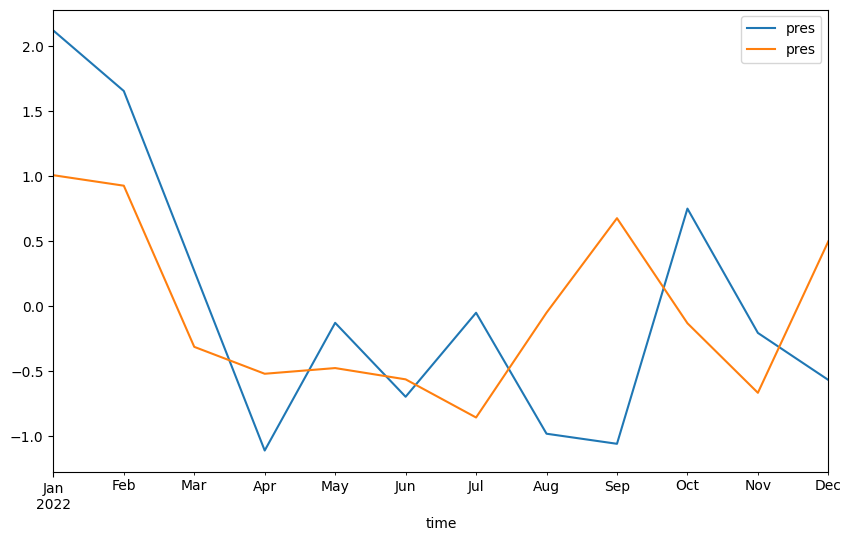

In [133]:
# ax1 = train.plot()
ax1 = test.plot()
predictions_df.plot(ax=ax1);

In [130]:
print('HistGradientBoostRegressor MSE:', round(mean_squared_error(test, predictions_df.values),2))
print('HistGradientBoostRegressor MAE:', round(mean_absolute_error(test, predictions_df.values),3))

HistGradientBoostRegressor MSE: 0.77
HistGradientBoostRegressor MAE: 0.78


# Comparison of methods